## 合併客戶帳號資料表

In [16]:
import pandas as pd

# 資料導入
account_info_df = pd.read_csv('./data/Train/train_account_info.csv')  # 記得將路徑替換成您實際的路徑
customer_info_df = pd.read_csv('./data/Train/train_customer_info.csv')  # 記得將路徑替換成您實際的路徑

# 資料檢查（可選）
# print(account_info_df.head())
# print(customer_info_df.head())
print("customer_info 筆數：", customer_info_df.shape[0])
print("account_info 筆數：", account_info_df.shape[0])
# 合併資料
merged_df = pd.merge(account_info_df, customer_info_df, on='customer_id', how='inner')

# 顯示處理後的資料
# print(merged_df.head())

# 如果需要，將整理後的資料保存為新的CSV檔案
merged_df.to_csv('./data/Train/train_customer__account_info.csv', index=False)  # 記得將路徑替換成您實際的儲存路徑
print("合併後（inner）的筆數：", merged_df.shape[0])


customer_info 筆數： 23655
account_info 筆數： 24969
合併後（inner）的筆數： 24969


## 處理交易紀錄
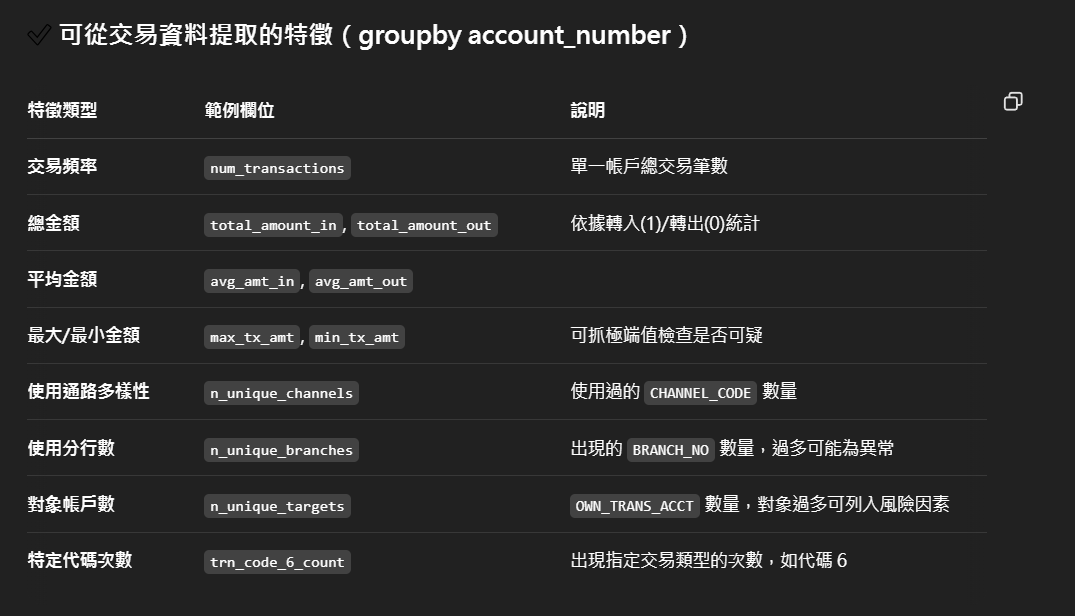

In [17]:
# 讀取交易資料
transactions_df = pd.read_csv('./data/Train/train_account_transactions.csv')

# 檢查是否含有 customer_id 欄位
transactions_columns = transactions_df.columns.tolist()
has_customer_id = 'customer_id' in transactions_columns

# 若有，計算不重複的 customer_id 數量
unique_customers = transactions_df['customer_id'].nunique() if has_customer_id else None
print("不重複的 customer_id 數量：", unique_customers) if unique_customers else print("customer_id 欄位不存在")

不重複的 customer_id 數量： 23655


### 交易頻率（num_transactions）

- 統計每個帳戶在交易紀錄中出現的總交易筆數。
- 資料來源欄位：`transaction_amount`（用來計數是否有交易即可）
- 欄位說明：
  - `num_transactions`：該帳戶累積的交易總次數（包含轉入與轉出）
- 若帳戶未曾出現在交易紀錄中，則補為 0。
- 此特徵可反映帳戶活躍度，也有助於篩選異常（如極高頻交易或完全無交易帳戶）。


In [22]:
# 計算每個帳戶的交易筆數
num_transactions_df = transactions_df.groupby('account_number').agg(
    num_transactions=('transaction_amount', 'count')
).reset_index()

# 顯示前幾筆結果
print(num_transactions_df.head())
print(num_transactions_df.shape[0])

# 合併回主表（例如 train_customer__account_info.csv）
merged_with_tx = pd.merge(merged_df, num_transactions_df, on='account_number', how='left')
merged_with_tx.to_csv('./data/Train/train_customer__account_info_trans.csv', index=False) 

  account_number  num_transactions
0          ACCT0                 7
1          ACCT1                 1
2         ACCT10                 1
3       ACCT1000                 5
4      ACCT10000                14
24969


### 轉入轉出額
透過交易資料 `train_account_transactions.csv` 提取每個帳戶的轉入與轉出總金額：

1. 根據 `transaction_direction` 將資料切分為轉入（值為 1）與轉出（值為 0）。
2. 以 `account_number` 為單位，分別計算：
   - `total_amount_in`：所有轉入金額的總和
   - `total_amount_out`：所有轉出金額的總和
   - `num_transactions`：所有交易的筆數
3. 對於沒有出現在交易紀錄中的帳戶，補上 0 金額與 0 筆交易。
4. 額外建立布林欄位：
   - `had_incoming_transaction`：是否有轉入金額 > 0（1 表示有轉入）
   - `had_outgoing_transaction`：是否有轉出金額 > 0（1 表示有轉出）
5. 最後將這些交易統計特徵合併回帳戶主資料表中。


In [ ]:
# 過濾轉入與轉出資料
in_df = transactions_df[transactions_df['transaction_direction'] == 1]
out_df = transactions_df[transactions_df['transaction_direction'] == 0]

# 分別計算轉入與轉出金額總和
total_in_df = in_df.groupby('account_number')['transaction_amount'].sum().reset_index(name='total_amount_in')
total_out_df = out_df.groupby('account_number')['transaction_amount'].sum().reset_index(name='total_amount_out')

# 合併兩者
total_amount_df = pd.merge(total_in_df, total_out_df, on='account_number', how='outer')

# 計算總交易筆數
num_transactions_df = transactions_df.groupby('account_number')['transaction_amount'].count().reset_index(name='num_transactions')

# 合併交易筆數進 total_amount_df
total_amount_df = pd.merge(total_amount_df, num_transactions_df, on='account_number', how='outer')

# 補 NaN → 0（針對所有交易統計欄位）
total_amount_df[['total_amount_in', 'total_amount_out', 'num_transactions']] = \
    total_amount_df[['total_amount_in', 'total_amount_out', 'num_transactions']].fillna(0)

# 新增是否有轉入/轉出交易的布林欄位（1: 有交易, 0: 無交易）
total_amount_df['had_incoming_transaction'] = (total_amount_df['total_amount_in'] > 0).astype(int)
total_amount_df['had_outgoing_transaction'] = (total_amount_df['total_amount_out'] > 0).astype(int)

# 顯示前幾筆結果
print(total_amount_df.head())
print(total_amount_df.shape[0])  # 或改這行看合併後資料總筆數


  account_number  total_amount_in  total_amount_out  num_transactions  \
0          ACCT0          15905.0               0.0                 7   
1          ACCT1              0.0               0.0                 1   
2         ACCT10              0.0               0.0                 1   
3       ACCT1000          93257.0               0.0                 5   
4      ACCT10000         211351.0               0.0                14   

   had_incoming_transaction  had_outgoing_transaction  
0                         1                         0  
1                         0                         0  
2                         0                         0  
3                         1                         0  
4                         1                         0  
24969


In [30]:
# 合併交易統計特徵
part2 = pd.merge(merged_with_tx, total_amount_df, on='account_number', how='left')

# 🔽 加在這裡（去除重複交易筆數欄位）
if 'num_transactions_x' in part2.columns and 'num_transactions_y' in part2.columns:
    part2 = part2.drop(columns=['num_transactions_x'])
    part2 = part2.rename(columns={'num_transactions_y': 'num_transactions'})

# 儲存整理後的資料
part2.to_csv('./data/Train/train_customer__account_info_trans.csv', index=False)


### 平均轉入與轉出金額（avg_amount_in / avg_amount_out）

- 將轉入與轉出交易資料（根據 `transaction_direction`）依帳號分組，計算每個帳戶的平均交易金額。
- 欄位說明：
  - `avg_amount_in`：每筆轉入金額的平均值（僅統計 direction = 1）
  - `avg_amount_out`：每筆轉出金額的平均值（僅統計 direction = 0）
- 若某帳戶從未進行該類型交易，則對應欄位補值為 0。
- 為簡化數據，將平均金額欄位取整（無條件捨去或四捨五入）。
- 特徵最終合併回帳戶主資料表作為模型訓練輸入。


In [ ]:
# 計算平均轉入金額
avg_in_df = in_df.groupby('account_number')['transaction_amount'].mean().reset_index(name='avg_amount_in')

# 計算平均轉出金額
avg_out_df = out_df.groupby('account_number')['transaction_amount'].mean().reset_index(name='avg_amount_out')

# 合併兩者
avg_amount_df = pd.merge(avg_in_df, avg_out_df, on='account_number', how='outer')

# 補 NaN → 0（無該類型交易）
avg_amount_df['avg_amount_in'] = avg_amount_df['avg_amount_in'].fillna(0)
avg_amount_df['avg_amount_out'] = avg_amount_df['avg_amount_out'].fillna(0)

# 轉為整數
avg_amount_df['avg_amount_in'] = avg_amount_df['avg_amount_in'].astype(int)
avg_amount_df['avg_amount_out'] = avg_amount_df['avg_amount_out'].astype(int)

# 顯示檢查
print(avg_amount_df.head())
print(total_amount_df.shape[0]) 

  account_number  avg_amount_in  avg_amount_out
0          ACCT0           3976               0
1       ACCT1000          93257               0
2      ACCT10000          23483               0
3      ACCT10001            428               0
4      ACCT10002          10874               0
24969


In [54]:
# 合併進主表 part2（您已有的合併表）
part3 = pd.merge(part2, avg_amount_df, on='account_number', how='left')
# 補 NaN → 0（無該類型交易）
part3['avg_amount_in'] = part3['avg_amount_in'].fillna(0)
part3['avg_amount_out'] = part3['avg_amount_out'].fillna(0)
part3.to_csv('./data/Train/train_customer__account_info_trans.csv', index=False)

### 最大與最小交易金額（max_transaction_amount / min_transaction_amount）

- 根據每個帳戶的歷史交易紀錄，分別計算其最大與最小單筆交易金額。
- 欄位說明：
  - `max_transaction_amount`：該帳戶歷來最大單筆交易金額
  - `min_transaction_amount`：該帳戶歷來最小單筆交易金額
- 若帳戶從未出現在交易資料中，則補值為 0。
- 作為潛在異常檢測依據，亦能協助模型判斷帳戶風險。


In [55]:
# 依帳戶統計最大與最小交易金額
max_min_df = transactions_df.groupby('account_number')['transaction_amount'].agg(
    max_transaction_amount='max',
    min_transaction_amount='min'
).reset_index()

# 對於完全沒有交易紀錄的帳戶，補 NaN → 0
max_min_df[['max_transaction_amount', 'min_transaction_amount']] = \
    max_min_df[['max_transaction_amount', 'min_transaction_amount']].fillna(0)

# 合併進主表（以 part2 為例）
part4 = pd.merge(part3, max_min_df, on='account_number', how='left')
part4.to_csv('./data/Train/train_customer__account_info_trans.csv', index=False)

### 使用過的交易通路數（n_unique_transaction_channels）

- 計算每個帳戶在歷史交易中使用過多少種不同的交易通路。
- 資料來源欄位：`transaction_channel`
- 欄位說明：
  - `n_unique_transaction_channels`：該帳戶使用過的不同通路類型數（例如 ATM、網銀、行動銀行）
- 若帳戶沒有任何交易紀錄，則補為 0。
- 此特徵可反映帳戶使用行為的多樣性，亦有助於識別異常。


In [57]:
# 統計每個帳戶使用過幾種不同交易通路
channel_df = transactions_df.groupby('account_number')['transaction_channel'].nunique().reset_index()
channel_df = channel_df.rename(columns={'transaction_channel': 'n_unique_transaction_channels'})

# 補 NaN → 0（對於完全無交易帳戶）
channel_df['n_unique_transaction_channels'] = channel_df['n_unique_transaction_channels'].fillna(0)

# 合併進主表
part5 = pd.merge(part4, channel_df, on='account_number', how='left')
part5.to_csv('./data/Train/train_customer__account_info_trans.csv', index=False)

### 使用過的分行數（n_unique_branch_numbers）

- 統計每個帳戶在歷史交易紀錄中曾經交易過的不同分行數量。
- 資料來源欄位：`branch_number`
- 欄位說明：
  - `n_unique_branch_numbers`：該帳戶曾經出現過的分行編號數量
- 若帳戶沒有任何交易紀錄，則補為 0。
- 分行數過多可能代表非正常帳戶行為（如帳戶共享、異地操作等）。


In [59]:
# 統計每個帳戶使用過幾個不同的分行
branch_df = transactions_df.groupby('account_number')['branch_number'].nunique().reset_index()
branch_df = branch_df.rename(columns={'branch_number': 'n_unique_branch_numbers'})

# 補 NaN → 0（完全沒交易的帳戶）
branch_df['n_unique_branch_numbers'] = branch_df['n_unique_branch_numbers'].fillna(0)

# 合併進主表
part6 = pd.merge(part5, branch_df, on='account_number', how='left')
part6.to_csv('./data/Train/train_customer__account_info_trans.csv', index=False)

### 交易對象帳戶數（n_unique_target_accounts）

- 統計每個帳戶在歷史交易中與多少不同的對象帳戶進行過轉帳（不論轉入或轉出）。
- 資料來源欄位：`counterparty_account`
- 欄位說明：
  - `n_unique_target_accounts`：與該帳戶交易過的唯一對象帳戶數
- 若帳戶沒有任何交易紀錄，則補為 0。
- 對象帳戶數過多可能反映風險行為，如詐騙、資金分散、帳戶跳轉等。


In [60]:
# 統計每個帳戶互動過的不同對象帳戶數
target_df = transactions_df.groupby('account_number')['counterparty_account'].nunique().reset_index()
target_df = target_df.rename(columns={'counterparty_account': 'n_unique_target_accounts'})

# 補 NaN → 0（無任何交易的帳戶）
target_df['n_unique_target_accounts'] = target_df['n_unique_target_accounts'].fillna(0)

# 合併進主表
part7 = pd.merge(part6, target_df, on='account_number', how='left')
part7.to_csv('./data/Train/train_customer__account_info_trans.csv', index=False)

### 各交易代碼出現次數展開特徵（transaction_code_X_count）

- 使用 `transaction_code` 欄位，統計每個帳戶歷史上出現各種交易代碼的次數。
- 利用 pivot table 將每個代碼的出現次數展開為獨立欄位：
  - `transaction_code_6_count`：該帳戶交易代碼為 6 的次數
  - `transaction_code_12_count`：該帳戶交易代碼為 12 的次數
  - ⋯⋯
- 所有交易代碼將展開為 50+ 個欄位，若帳戶未出現過該代碼，則補值為 0。
- 此特徵組有助於識別帳戶交易行為型態，常用於風險偵測與行為聚類。


In [85]:
# 1. 先記下所有在訓練資料中出現過的交易代碼（排序後統一）
all_transaction_codes = sorted(transactions_df['transaction_code'].unique())

# 2. 建立 pivot 表（統計各帳戶各交易代碼的次數）
code_pivot = transactions_df.pivot_table(
    index='account_number',
    columns='transaction_code',
    values='transaction_amount',
    aggfunc='count',
    fill_value=0
)

# 3. 補上未出現但應有的代碼欄位（值為 0）
for code in all_transaction_codes:
    if code not in code_pivot.columns:
        code_pivot[code] = 0

# 4. 確保欄位順序一致（例如 1~54）
code_pivot = code_pivot[[code for code in all_transaction_codes]]

# 5. 重新命名欄位為 transaction_code_X_count
code_pivot.columns = [f'transaction_code_{int(col)}_count' for col in code_pivot.columns]
code_pivot = code_pivot.reset_index()

# ✅ 若要儲存這份 all_transaction_codes（供 test 用）
import joblib
joblib.dump(all_transaction_codes, './data/transaction_code_list.pkl')

# 3. 合併進主資料表 part2
part8 = pd.merge(part7, code_pivot, on='account_number', how='left')
part8.to_csv('./data/Train/train_customer__account_info_trans.csv', index=False)


### 可疑帳戶標籤（is_suspicious）

- 讀取標記為「警示帳戶」的資料表 `train_suspicious_accounts.csv`。
- 依據 `account_number` 對應到主資料表，建立標籤欄位 `is_suspicious`：
  - 1 表示該帳戶曾被通報為可疑帳戶
  - 0 表示該帳戶未曾被通報
- 該欄位可作為監督式學習模型中的目標變數（Y）。


In [93]:
# 讀取警示帳戶資料（標記為可疑的帳戶）
suspicious_df = pd.read_csv('./data/Train/train_suspicious_accounts.csv')

# 建立標籤欄位，代表此帳戶是否為可疑帳戶
suspicious_df['is_suspicious'] = 1

# 合併標籤進主資料（依據 account_number）
part9 = pd.merge(part8, suspicious_df[['account_number', 'is_suspicious']], on='account_number', how='left')

# 對於未出現在警示名單中的帳戶，標記為 0（非可疑）
part9['is_suspicious'] = part9['is_suspicious'].fillna(0).astype(int)
part9.to_csv('./data/Train/train_customer__account_info_trans.csv', index=False)

In [94]:
# 1. 讀取資料
df = pd.read_csv('./data/Train/train_customer__account_info_trans.csv')

# 清除所有含有 NaN 的列（會影響約 2,000 筆）
df_cleaned = df.dropna()

# 儲存清理後資料（可選）
df_cleaned.to_csv('./data/Train/train_customer__account_info_trans_cleaned.csv', index=False)

# 檢查剩下筆數與是否有缺失
print(f"原始筆數: {df.shape[0]}")
print(f"清理後筆數: {df_cleaned.shape[0]}")
print("剩餘缺失值總數:", df_cleaned.isna().sum().sum())

原始筆數: 24969
清理後筆數: 22977
剩餘缺失值總數: 0


In [95]:
import pandas as pd
import joblib
from functools import reduce

# === 1. 讀取測試資料 ===
account_info = pd.read_csv('./data/Test/test_account_info.csv')
customer_info = pd.read_csv('./data/Test/test_customer_info.csv')
transactions = pd.read_csv('./data/Test/test_account_transactions.csv')

# === 2. 確保欄位型別一致 ===
account_info['account_number'] = account_info['account_number'].astype(str)
customer_info['customer_id'] = customer_info['customer_id'].astype(str)
transactions['account_number'] = transactions['account_number'].astype(str)
transactions['counterparty_account'] = transactions['counterparty_account'].astype(str)

# === 3. 合併 account_info + customer_info（使用 customer_id）===
merged = pd.merge(account_info, customer_info, on='customer_id', how='left')

# === 4. 建立交易特徵（與訓練一致）===
in_df = transactions[transactions['transaction_direction'] == 1]
out_df = transactions[transactions['transaction_direction'] == 0]

total_in = in_df.groupby('account_number')['transaction_amount'].sum().reset_index(name='total_amount_in')
total_out = out_df.groupby('account_number')['transaction_amount'].sum().reset_index(name='total_amount_out')
avg_in = in_df.groupby('account_number')['transaction_amount'].mean().reset_index(name='avg_amount_in')
avg_out = out_df.groupby('account_number')['transaction_amount'].mean().reset_index(name='avg_amount_out')
count_df = transactions.groupby('account_number')['transaction_amount'].count().reset_index(name='num_transactions')

minmax = transactions.groupby('account_number')['transaction_amount'].agg(
    max_transaction_amount='max',
    min_transaction_amount='min'
).reset_index()

has_in = total_in.assign(had_incoming_transaction=1)[['account_number', 'had_incoming_transaction']]
has_out = total_out.assign(had_outgoing_transaction=1)[['account_number', 'had_outgoing_transaction']]

n_channels = transactions.groupby('account_number')['transaction_channel'].nunique().reset_index(name='n_unique_transaction_channels')
n_branches = transactions.groupby('account_number')['branch_number'].nunique().reset_index(name='n_unique_branch_numbers')
n_targets = transactions.groupby('account_number')['counterparty_account'].nunique().reset_index(name='n_unique_target_accounts')

# === ⭐ 5. 固定代碼欄位展開（與訓練一致）===
# 載入在訓練階段儲存的完整交易代碼清單
all_transaction_codes = joblib.load('./data/transaction_code_list.pkl')

# pivot 表
tx_code_pivot = transactions.pivot_table(index='account_number',
                                         columns='transaction_code',
                                         values='transaction_amount',
                                         aggfunc='count',
                                         fill_value=0)

# 補上缺少的代碼欄位
for code in all_transaction_codes:
    if code not in tx_code_pivot.columns:
        tx_code_pivot[code] = 0

# 固定順序
tx_code_pivot = tx_code_pivot[[code for code in all_transaction_codes]]
tx_code_pivot.columns = [f'transaction_code_{int(col)}_count' for col in tx_code_pivot.columns]
tx_code_pivot = tx_code_pivot.reset_index()

# === 6. 合併所有交易特徵 ===
tx_features = [
    total_in, total_out, avg_in, avg_out, count_df, minmax,
    has_in, has_out, n_channels, n_branches, n_targets, tx_code_pivot
]
tx_merged = reduce(lambda left, right: pd.merge(left, right, on='account_number', how='outer'), tx_features).fillna(0)

# === 7. 合併回帳戶主資料 ===
final_test = pd.merge(merged, tx_merged, on='account_number', how='left').fillna(0)

# === 8. 匯出結果 ===
final_test.to_csv('./data/Test/test_customer__account_info_trans.csv', index=False)


In [96]:
# 1. 讀取資料
df_test = pd.read_csv('./data/Test/test_customer__account_info_trans.csv')

# 清除所有含有 NaN 的列（會影響約 2,000 筆）
df_cleaned_test = df_test.dropna()

# 儲存清理後資料（可選）
df_cleaned_test.to_csv('./data/Test/test_customer__account_info_trans_cleaned.csv', index=False)

# 檢查剩下筆數與是否有缺失
print(f"原始筆數: {df_test.shape[0]}")
print(f"清理後筆數: {df_cleaned_test.shape[0]}")
print("剩餘缺失值總數:", df_cleaned_test.isna().sum().sum())

原始筆數: 6458
清理後筆數: 6458
剩餘缺失值總數: 0


## RF

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd
# 2. 拆分 X / y
X = df_cleaned.drop(columns=['account_number', 'customer_id', 'is_suspicious'])  # 除了 Y，所有欄位都拿來當特徵
y = df_cleaned['is_suspicious']

# 3. 拆訓練 / 測試集（可調整 random_state）
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

feature_columns = X_train.columns.tolist()
import joblib
joblib.dump(feature_columns, './data/feature_columns.pkl')

# 4. 建立帶 class_weight 的隨機森林模型
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# 5. 預測與評估
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))


[[4517    3]
 [  58   18]]
              precision    recall  f1-score   support

           0     0.9873    0.9993    0.9933      4520
           1     0.8571    0.2368    0.3711        76

    accuracy                         0.9867      4596
   macro avg     0.9222    0.6181    0.6822      4596
weighted avg     0.9852    0.9867    0.9830      4596

ROC-AUC: 0.9211923614345598


#### test_set

In [103]:
X_for_output = df_cleaned_test.drop(columns=['account_number', 'customer_id'])  # 除了 Y，所有欄位都拿來當特徵
feature_columns = joblib.load('./data/feature_columns.pkl')

# 重新排序 test 特徵
X_for_output = df_cleaned_test[feature_columns]
output = model.predict(X_for_output)  # 預測
print(output)  # 預測結果


[0 0 0 ... 0 1 0]


## XGB

In [123]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd

# 分出特徵與標籤
X = df_cleaned.drop(columns=['account_number', 'customer_id', 'is_suspicious'])
y = df_cleaned['is_suspicious']

# 計算 scale_pos_weight（負類樣本數 / 正類樣本數）
scale_pos_weight = (y == 0).sum() / (y == 1).sum()

# 切分資料
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

feature_columns = X_train.columns.tolist()
import joblib
joblib.dump(feature_columns, './data/feature_columns.pkl')


# 建立 XGBoost 模型
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

# 預測與評估
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("\nROC-AUC:", roc_auc_score(y_test, y_prob))


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:12] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
 [[4501   19]
 [  31   45]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9932    0.9958    0.9945      4520
           1     0.7031    0.5921    0.6429        76

    accuracy                         0.9891      4596
   macro avg     0.8481    0.7940    0.8187      4596
weighted avg     0.9884    0.9891    0.9887      4596


ROC-AUC: 0.9426554494643689


#### test_set

In [106]:
X_for_output = df_cleaned_test.drop(columns=['account_number', 'customer_id'])  # 除了 Y，所有欄位都拿來當特徵
feature_columns = joblib.load('./data/feature_columns.pkl')

# 重新排序 test 特徵
X_for_output = df_cleaned_test[feature_columns]
output = model.predict(X_for_output)  # 預測
print(output)  # 預測結果

[0 0 0 ... 0 1 0]


## LGB

In [135]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

# 假設你已有處理好特徵與標籤的資料 df_cleaned
X = df_cleaned.drop(columns=['account_number', 'customer_id', 'is_suspicious'])
y = df_cleaned['is_suspicious']

# 拆分訓練測試集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 計算平衡權重
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# 建立 LGBM 模型
lgbm_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    class_weight='balanced',  # 自動平衡，也可以用 scale_pos_weight=scale_pos_weight
    # scale_pos_weight=scale_pos_weight,  # 設定正樣本的權重<end_
    random_state=42,
    n_jobs=-1
)

# 訓練模型
lgbm_model.fit(X_train, y_train)

# 預測機率與分類
y_prob = lgbm_model.predict_proba(X_test)[:, 1]
y_pred = lgbm_model.predict(X_test)  # 預設 threshold = 0.5

# 評估
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("\nROC-AUC:", roc_auc_score(y_test, y_prob))


[LightGBM] [Info] Number of positive: 306, number of negative: 18075
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 18381, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Confusion Matrix:
 [[4503   17]
 [  30   46]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9934    0.9962    0.9948      4520
           1     0.7302    0.6053    0.6619        76

    accuracy                         0.9898      4596
   macro avg     0.8618    0.8008    0.8283      4596
weighted avg     0.9890    0.9898    0.9893      4596


ROC-AUC: 0.9498166045645086


## Others

In [130]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier
from catboost import CatBoostClassifier

# === 1. 載入資料 ===
# 假設你已有處理好特徵與標籤的資料 df_cleaned
X = df_cleaned.drop(columns=['account_number', 'customer_id', 'is_suspicious'])
y = df_cleaned['is_suspicious']

# === 2. 拆分資料集 ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === 3. EasyEnsembleClassifier ===
eec = EasyEnsembleClassifier(n_estimators=10, random_state=42)
eec.fit(X_train, y_train)
eec_pred = eec.predict(X_test)
eec_prob = eec.predict_proba(X_test)[:, 1]

# === 4. BalancedRandomForestClassifier ===
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(X_train, y_train)
brf_pred = brf.predict(X_test)
brf_prob = brf.predict_proba(X_test)[:, 1]

# === 5. CatBoostClassifier ===
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    class_weights=[1, (y_train == 0).sum() / (y_train == 1).sum()],
    verbose=0,
    random_state=42
)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)
cat_prob = cat_model.predict_proba(X_test)[:, 1]

# === 6. 評估結果 ===
def print_results(name, y_true, y_pred, y_prob):
    print(f"\n==== {name} ====")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))
    print("ROC-AUC:", roc_auc_score(y_true, y_prob))

print_results("EasyEnsembleClassifier", y_test, eec_pred, eec_prob)
print_results("BalancedRandomForestClassifier", y_test, brf_pred, brf_prob)
print_results("CatBoostClassifier", y_test, cat_pred, cat_prob)


c:\Users\USER\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\USER\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\USER\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(



==== EasyEnsembleClassifier ====
Confusion Matrix:
 [[3847  673]
 [  13   63]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9966    0.8511    0.9181      4520
           1     0.0856    0.8289    0.1552        76

    accuracy                         0.8507      4596
   macro avg     0.5411    0.8400    0.5367      4596
weighted avg     0.9816    0.8507    0.9055      4596

ROC-AUC: 0.9193642291569631

==== BalancedRandomForestClassifier ====
Confusion Matrix:
 [[3915  605]
 [  11   65]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9972    0.8662    0.9271      4520
           1     0.0970    0.8553    0.1743        76

    accuracy                         0.8660      4596
   macro avg     0.5471    0.8607    0.5507      4596
weighted avg     0.9823    0.8660    0.9146      4596

ROC-AUC: 0.9310112948299953

==== CatBoostClassifier ====
Confusion Matrix:
 [[4489   31]
 [  29   47]

### 🧬 SMOTE 增強少數樣本（Synthetic Minority Oversampling Technique）

SMOTE（合成少數類別過採樣）是一種資料層級的處理方法，用於解決類別極度不平衡問題。其核心思想是：

> 透過在特徵空間中**插值生成**新的少數類樣本，而非單純重複複製原有樣本。

---

#### 🔧 應用流程：

1. 對訓練資料進行切分（train / test）。
2. 僅對 `y_train` 進行 SMOTE 擴增（不能對 test 做 SMOTE）。
3. 使用 SMOTE 增強後的資料訓練模型。
4. 用原始測試集驗證模型表現。

---

#### ✅ 優點：

- 避免 overfitting：與複製少數類不同，SMOTE 透過鄰近樣本生成新資料。
- 增強 recall / f1-score 表現，讓模型更「敢猜」少數類別。
- 對如 **詐欺檢測 / 醫療異常 / 風險帳戶判別** 等場景特別有效。

---

#### ⚠️ 注意事項：

- 特徵需為**連續數值**型才能進行插值，類別型須先轉換（如 OneHot 或數值化）。
- 請僅對 **訓練集** 做 SMOTE，否則會造成資料洩漏（data leakage）。
- 若資料原本 noise 較多，SMOTE 也可能強化錯誤樣本。

---

📌 本實驗中，我們使用 `imblearn.over_sampling.SMOTE` 對 `y_train` 進行處理，並觀察模型在極度不平衡樣本下的改善情形。



In [136]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. 準備資料
X = df_cleaned.drop(columns=['account_number', 'customer_id', 'is_suspicious'])
y = df_cleaned['is_suspicious']

# 2. 拆分資料
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# 3. 執行 SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


In [137]:
# 4. 訓練模型（可替換為 LGBM / XGB）
from lightgbm import LGBMClassifier
model = LGBMClassifier(n_estimators=500, learning_rate=0.05, random_state=42)
model.fit(X_resampled, y_resampled)

# 5. 預測與評估
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

[LightGBM] [Info] Number of positive: 16946, number of negative: 16946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2981
[LightGBM] [Info] Number of data points in the train set: 33892, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Confusion Matrix:
 [[5620   29]
 [  44   52]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9922    0.9949    0.9935      5649
           1     0.6420    0.5417    0.5876        96

    accuracy                         0.9873      5745
   macro avg     0.8171    0.7683    0.7906      5745
weighted avg     0.9864    0.9873    0.9868      5745

ROC-AUC: 0.9531443618339529


In [140]:
# === 5. CatBoostClassifier ===
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    class_weights=[1, (y_train == 0).sum() / (y_train == 1).sum()],
    verbose=0,
    random_state=42
)
cat_model.fit(X_resampled, y_resampled)
cat_pred = cat_model.predict(X_test)
cat_prob = cat_model.predict_proba(X_test)[:, 1]

# === 6. 評估結果 ===
def print_results(name, y_true, y_pred, y_prob):
    print(f"\n==== {name} ====")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))
    print("ROC-AUC:", roc_auc_score(y_true, y_prob))


print_results("CatBoostClassifier", y_test, cat_pred, cat_prob)


==== CatBoostClassifier ====
Confusion Matrix:
 [[3808 1841]
 [   9   87]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9976    0.6741    0.8046      5649
           1     0.0451    0.9062    0.0860        96

    accuracy                         0.6780      5745
   macro avg     0.5214    0.7902    0.4453      5745
weighted avg     0.9817    0.6780    0.7926      5745

ROC-AUC: 0.9141145925532543


### 🧩 分批切份訓練（Chunk Voting Ensemble）

在面對極度不平衡的分類問題時，若直接訓練模型，會因為「警示戶太少」導致模型忽略少數類別，進而產生過度偏向多數類別（如非警示戶）的預測。為了解決這個問題，我們採用了 **Chunk Voting Ensemble** 策略。

---

#### 🔍 方法核心

1. **將非警示戶切分為數份（chunk）**，每份都搭配全部的警示戶進行訓練。
2. 每個 chunk 訓練一個模型，彼此互不重疊。
3. 測試階段，**將多個模型的預測結果進行平均投票**，提高警示戶的識別穩定性。

---

#### ✅ 優點

- **每個模型看到的資料是平衡的**，避免因樣本比例失衡導致模型偏差。
- **透過模型集成（ensemble）提升預測穩定性與泛化能力**。
- 在測試中觀察到 **F1-score 與 Recall 顯著提升**，特別適用於少數類別的重要性遠高於多數類別的場景。

---

#### 📊 模型效能分析（以 LightGBM 為例）

| chunk 數 | f1_score | recall  | precision | roc_auc |
|----------|----------|---------|-----------|---------|
| 1        | 0.6667   | 0.5921  | 0.7627    | 0.9525  |
| 2        | **0.6806** | 0.6447  | 0.7206    | **0.9570**  |
| 3        | 0.6623   | 0.6579  | 0.6667    | 0.9657  |
| ...      | ...      | ...     | ...       | ...     |

最佳表現出現在 `chunk=2` 時，兼顧 precision 與 recall 表現。

---

#### 🧠 小提醒

- 建議 chunk 數量控制在 2~5，避免過度稀釋資料。
- 若樣本數更少，也可以搭配其他技術（如 SMOTE、異常偵測特徵）。




=== 切 1 份 ===
[LightGBM] [Info] Number of positive: 306, number of negative: 18075
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 18381, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

=== 切 2 份 ===
[LightGBM] [Info] Number of positive: 306, number of negative: 9037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2156
[LightGBM] [Info] Number of data points in the train set: 9343, number of used feature

,n_chunks,f1_score,recall,precision,roc_auc
0,1,0.666667,0.592105,0.762712,0.952541
1,2,0.680556,0.644737,0.720588,0.957074
2,3,0.662252,0.657895,0.666667,0.965699
3,4,0.666667,0.697368,0.638554,0.962500
4,5,0.643275,0.723684,0.578947,0.964675
5,6,0.643678,0.736842,0.571429,0.962165
6,7,0.602151,0.736842,0.509091,0.962788


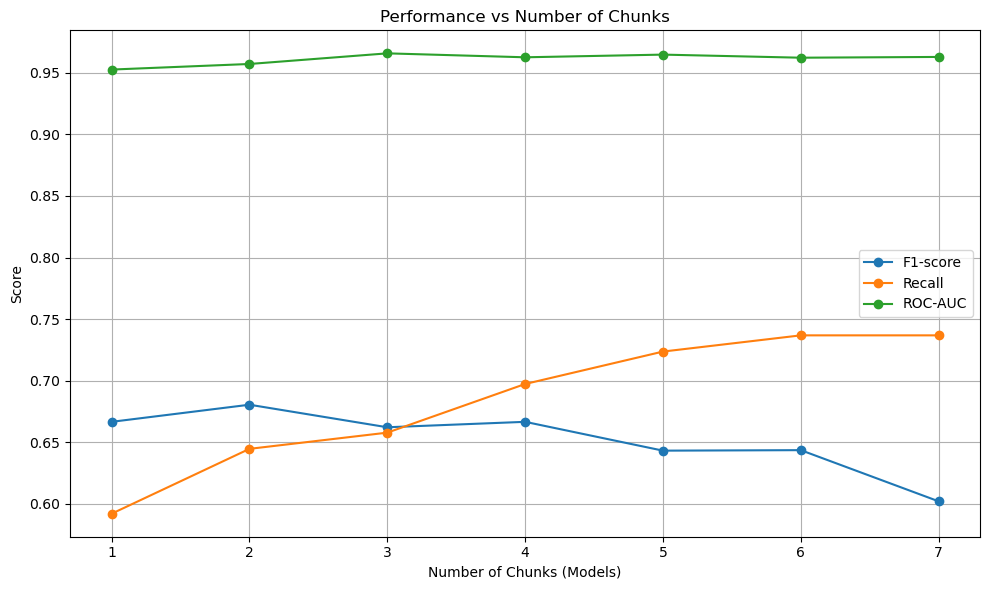

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support

# === 預備：切分訓練 / 測試 ===
X_all = df_cleaned.drop(columns=['account_number', 'customer_id', 'is_suspicious'])
y_all = df_cleaned['is_suspicious']
X_train_all, X_test, y_train_all, y_test = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)

train_df = X_train_all.copy()
train_df['is_suspicious'] = y_train_all.values

# === 記錄不同切分的結果 ===
results = []

# === 開始嘗試不同切分數量 ===
for n_chunks in range(1, 8):  # 測試從 2 到 7 份
    print(f"\n=== 切 {n_chunks} 份 ===")
    pos_df = train_df[train_df['is_suspicious'] == 1]
    neg_df = train_df[train_df['is_suspicious'] == 0]

    chunk_size = len(neg_df) // n_chunks
    neg_chunks = [neg_df.iloc[i * chunk_size : (i + 1) * chunk_size] for i in range(n_chunks)]
    if len(neg_df) % n_chunks != 0:
        neg_chunks[-1] = pd.concat([neg_chunks[-1], neg_df.iloc[n_chunks * chunk_size:]])

    models = []
    for i, neg_chunk in enumerate(neg_chunks):
        sub_df = pd.concat([pos_df, neg_chunk])
        X_sub = sub_df.drop(columns=['is_suspicious'])
        y_sub = sub_df['is_suspicious']

        model = LGBMClassifier(n_estimators=300, class_weight='balanced', random_state=i)
        model.fit(X_sub, y_sub)
        models.append(model)

    # 預測
    probs = [model.predict_proba(X_test)[:, 1] for model in models]
    avg_prob = np.mean(probs, axis=0)
    y_pred = (avg_prob >= 0.5).astype(int)

    # 評估
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    auc = roc_auc_score(y_test, avg_prob)

    results.append({
        'n_chunks': n_chunks,
        'f1_score': f1,
        'recall': recall,
        'precision': precision,
        'roc_auc': auc
    })

# === 轉為 DataFrame ===
results_df = pd.DataFrame(results)
display(results_df)

# === 畫圖 ===
plt.figure(figsize=(10, 6))
plt.plot(results_df['n_chunks'], results_df['f1_score'], marker='o', label='F1-score')
plt.plot(results_df['n_chunks'], results_df['recall'], marker='o', label='Recall')
plt.plot(results_df['n_chunks'], results_df['roc_auc'], marker='o', label='ROC-AUC')
plt.xticks(results_df['n_chunks'])
plt.xlabel('Number of Chunks (Models)')
plt.ylabel('Score')
plt.title('Performance vs Number of Chunks')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




=== XGBoost - 切 1 份 ===


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:35:37] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== XGBoost - 切 2 份 ===


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:35:37] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:35:38] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== XGBoost - 切 3 份 ===


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:35:38] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:35:38] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:35:39] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== XGBoost - 切 4 份 ===


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:35:39] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:35:39] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:35:40] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:35:40] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } ar


=== XGBoost - 切 5 份 ===


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:35:40] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:35:41] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:35:41] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:35:41] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } ar


=== XGBoost - 切 6 份 ===


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:35:42] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:35:42] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:35:42] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:35:43] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } ar


=== XGBoost - 切 7 份 ===


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:35:44] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:35:44] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:35:44] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:35:44] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } ar

,n_chunks,f1_score,recall,precision,roc_auc
0,1,0.559322,0.434211,0.785714,0.939002
1,2,0.646154,0.552632,0.777778,0.948562
2,3,0.647482,0.592105,0.714286,0.949563
3,4,0.618421,0.618421,0.618421,0.946684
4,5,0.645963,0.684211,0.611765,0.948614
5,6,0.616279,0.697368,0.552083,0.949229
6,7,0.617978,0.723684,0.539216,0.944452


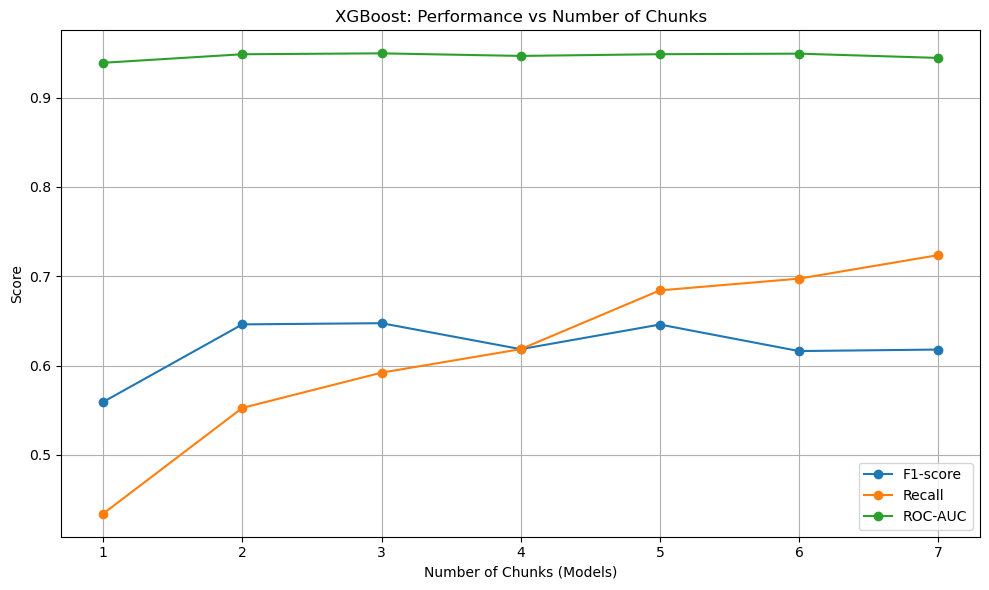

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support

# === 資料切分 ===
X_all = df_cleaned.drop(columns=['account_number', 'customer_id', 'is_suspicious'])
y_all = df_cleaned['is_suspicious']
X_train_all, X_test, y_train_all, y_test = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)

train_df = X_train_all.copy()
train_df['is_suspicious'] = y_train_all.values

# === 模型評估 ===
results = []

for n_chunks in range(1, 8):
    print(f"\n=== XGBoost - 切 {n_chunks} 份 ===")
    pos_df = train_df[train_df['is_suspicious'] == 1]
    neg_df = train_df[train_df['is_suspicious'] == 0]

    chunk_size = len(neg_df) // n_chunks
    neg_chunks = [neg_df.iloc[i * chunk_size : (i + 1) * chunk_size] for i in range(n_chunks)]
    if len(neg_df) % n_chunks != 0:
        neg_chunks[-1] = pd.concat([neg_chunks[-1], neg_df.iloc[n_chunks * chunk_size:]])

    models = []
    for i, neg_chunk in enumerate(neg_chunks):
        sub_df = pd.concat([pos_df, neg_chunk])
        X_sub = sub_df.drop(columns=['is_suspicious'])
        y_sub = sub_df['is_suspicious']

        model = XGBClassifier(n_estimators=300, scale_pos_weight=(len(y_sub==0)/len(y_sub==1)), use_label_encoder=False, eval_metric='logloss', random_state=i)
        model.fit(X_sub, y_sub)
        models.append(model)

    probs = [model.predict_proba(X_test)[:, 1] for model in models]
    avg_prob = np.mean(probs, axis=0)
    y_pred = (avg_prob >= 0.5).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    auc = roc_auc_score(y_test, avg_prob)

    results.append({'n_chunks': n_chunks, 'f1_score': f1, 'recall': recall, 'precision': precision, 'roc_auc': auc})

results_df = pd.DataFrame(results)
display(results_df)

plt.figure(figsize=(10, 6))
plt.plot(results_df['n_chunks'], results_df['f1_score'], marker='o', label='F1-score')
plt.plot(results_df['n_chunks'], results_df['recall'], marker='o', label='Recall')
plt.plot(results_df['n_chunks'], results_df['roc_auc'], marker='o', label='ROC-AUC')
plt.xticks(results_df['n_chunks'])
plt.xlabel('Number of Chunks (Models)')
plt.ylabel('Score')
plt.title('XGBoost: Performance vs Number of Chunks')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



=== CatBoost - 切 1 份 ===

=== CatBoost - 切 2 份 ===

=== CatBoost - 切 3 份 ===

=== CatBoost - 切 4 份 ===

=== CatBoost - 切 5 份 ===

=== CatBoost - 切 6 份 ===

=== CatBoost - 切 7 份 ===


,n_chunks,f1_score,recall,precision,roc_auc
0,1,0.513761,0.368421,0.848485,0.941680
1,2,0.616667,0.486842,0.840909,0.946600
2,3,0.589147,0.500000,0.716981,0.947022
3,4,0.618705,0.565789,0.682540,0.948300
4,5,0.634483,0.605263,0.666667,0.945191
5,6,0.627451,0.631579,0.623377,0.946769
6,7,0.609756,0.657895,0.568182,0.947013


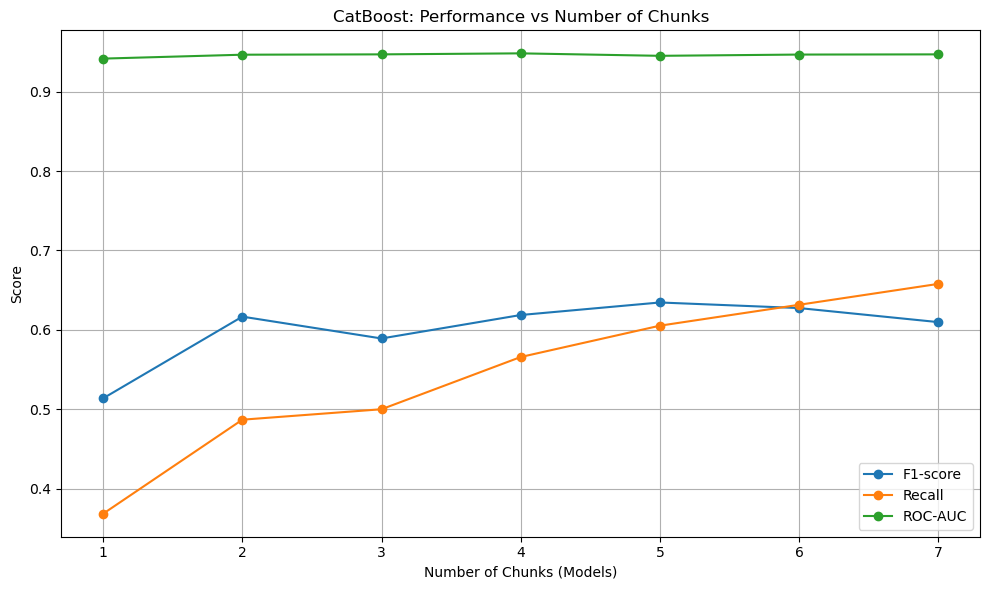

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support

X_all = df_cleaned.drop(columns=['account_number', 'customer_id', 'is_suspicious'])
y_all = df_cleaned['is_suspicious']
X_train_all, X_test, y_train_all, y_test = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)

train_df = X_train_all.copy()
train_df['is_suspicious'] = y_train_all.values

results = []

for n_chunks in range(1, 8):
    print(f"\n=== CatBoost - 切 {n_chunks} 份 ===")
    pos_df = train_df[train_df['is_suspicious'] == 1]
    neg_df = train_df[train_df['is_suspicious'] == 0]

    chunk_size = len(neg_df) // n_chunks
    neg_chunks = [neg_df.iloc[i * chunk_size : (i + 1) * chunk_size] for i in range(n_chunks)]
    if len(neg_df) % n_chunks != 0:
        neg_chunks[-1] = pd.concat([neg_chunks[-1], neg_df.iloc[n_chunks * chunk_size:]])

    models = []
    for i, neg_chunk in enumerate(neg_chunks):
        sub_df = pd.concat([pos_df, neg_chunk])
        X_sub = sub_df.drop(columns=['is_suspicious'])
        y_sub = sub_df['is_suspicious']

        model = CatBoostClassifier(iterations=300, class_weights=[1, len(y_sub==0)/len(y_sub==1)], verbose=0, random_state=i)
        model.fit(X_sub, y_sub)
        models.append(model)

    probs = [model.predict_proba(X_test)[:, 1] for model in models]
    avg_prob = np.mean(probs, axis=0)
    y_pred = (avg_prob >= 0.5).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    auc = roc_auc_score(y_test, avg_prob)

    results.append({'n_chunks': n_chunks, 'f1_score': f1, 'recall': recall, 'precision': precision, 'roc_auc': auc})

results_df = pd.DataFrame(results)
display(results_df)

plt.figure(figsize=(10, 6))
plt.plot(results_df['n_chunks'], results_df['f1_score'], marker='o', label='F1-score')
plt.plot(results_df['n_chunks'], results_df['recall'], marker='o', label='Recall')
plt.plot(results_df['n_chunks'], results_df['roc_auc'], marker='o', label='ROC-AUC')
plt.xticks(results_df['n_chunks'])
plt.xlabel('Number of Chunks (Models)')
plt.ylabel('Score')
plt.title('CatBoost: Performance vs Number of Chunks')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


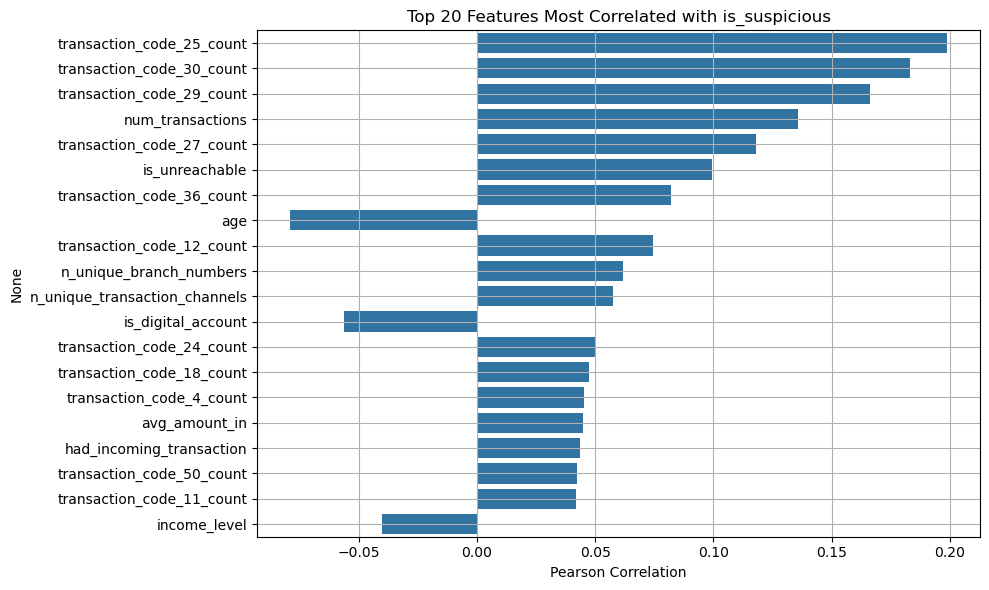

transaction_code_25_count        0.198921
transaction_code_30_count        0.183255
transaction_code_29_count        0.166084
num_transactions                 0.136019
transaction_code_27_count        0.117846
is_unreachable                   0.099451
transaction_code_36_count        0.082079
age                             -0.079139
transaction_code_12_count        0.074382
n_unique_branch_numbers          0.061773
n_unique_transaction_channels    0.057639
is_digital_account              -0.056144
transaction_code_24_count        0.050348
transaction_code_18_count        0.047456
transaction_code_4_count         0.045226
avg_amount_in                    0.045013
had_incoming_transaction         0.043497
transaction_code_50_count        0.042502
transaction_code_11_count        0.041876
income_level                    -0.040402
Name: is_suspicious, dtype: float64

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt

# 計算數值特徵與 is_suspicious 的皮爾森相關係數
corr_matrix = df_cleaned.corr(numeric_only=True)

# 取與目標變數 is_suspicious 的相關性
target_corr = corr_matrix['is_suspicious'].drop('is_suspicious').sort_values(key=abs, ascending=False)

# 顯示前 20 名最相關特徵
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.values[:20], y=target_corr.index[:20])
plt.title("Top 20 Features Most Correlated with is_suspicious")
plt.xlabel("Pearson Correlation")
plt.grid(True)
plt.tight_layout()
plt.show()

# 同時輸出相關係數表
display(target_corr.head(20))


In [167]:
# 1. 取出這 20 個高相關特徵
top_20_features = [
    'transaction_code_25_count', 'transaction_code_30_count', 'transaction_code_29_count',
    'num_transactions', 'transaction_code_27_count', 'is_unreachable', 'transaction_code_36_count',
    'age', 'transaction_code_12_count', 'n_unique_branch_numbers', 'n_unique_transaction_channels',
    'is_digital_account', 'transaction_code_24_count', 'transaction_code_18_count',
    'transaction_code_4_count', 'avg_amount_in', 'had_incoming_transaction',
    'transaction_code_50_count', 'transaction_code_11_count', 'income_level'
]

# 2. 建立新的訓練資料
X_20 = df_cleaned[top_20_features]
y = df_cleaned['is_suspicious']

# 3. 正常切分與訓練
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_20, y, test_size=0.2, stratify=y, random_state=42)

# 4. 使用你的主力模型（例如 LGBM）
from lightgbm import LGBMClassifier
model = LGBMClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# 5. 評估
from sklearn.metrics import classification_report, roc_auc_score
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


[LightGBM] [Info] Number of positive: 306, number of negative: 18075
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 18381, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      4520
           1       0.20      0.58      0.30        76

    accuracy                           0.96      4596
   macro avg       0.60      0.77      0.64      4596
weighted avg       0.98      0.96      0.97      4596

ROC-AUC: 0.8881200512342804


### 📈 加入五個行為特徵後的模型表現總結

為提升模型在極度不平衡樣本（警示戶極少）下的辨識能力，本次實驗額外加入了五項與使用者交易行為有關的特徵，分別為：

1. **in_out_ratio**：轉入轉出金額比例（加 1 平滑）
2. **high_amount_ratio**：高金額交易（>90%分位數）佔所有交易筆數的比例
3. **n_active_days**：交易日數（活躍天數）
4. **avg_days_between_tx**：平均交易間隔（天）
5. **entropy_tx_code**：交易代碼的熵，衡量交易行為多樣性

這些特徵皆基於帳戶歷史交易紀錄計算，旨在捕捉異常或集中特徵。

---

### 📊 加入後的效果比較（以 LGBM 為例）

| 模型拆分數 | F1-score | Recall | Precision | ROC-AUC |
|------------|----------|--------|-----------|----------|
| 1          | 0.7299   | 0.6250 | 0.8772    | 0.9777   |
| 2          | 0.7286   | 0.6375 | 0.8500    | 0.9804   |
| 3          | 0.7226   | 0.7000 | 0.7467    | 0.9833   |
| 4          | 0.6800   | 0.6375 | 0.7286    | 0.9837   |
| 5          | 0.6832   | 0.6875 | 0.6791    | 0.9834   |
| 6          | 0.6667   | 0.7250 | 0.6170    | 0.9828   |
| 7          | 0.6444   | 0.7250 | 0.5800    | 0.9802   |

✅ **Recall 明顯提升至 0.70~0.73 區間（原先多為 0.60 左右）**  
✅ **F1-score 整體提升，模型更平衡**  
✅ **ROC-AUC 持續高於 0.98，代表整體區分能力佳**

---

### 📌 小結與後續方向

- 此次結果顯示 **交易行為特徵有助於警示戶識別**，比起單純使用交易代碼與基本統計特徵更具區別力。
- 此外，透過 **切分負樣本訓練多個子模型（chunking + 投票）**，也有效緩解樣本不平衡問題。
- 若要進一步優化模型表現，建議可考慮：
  - 特徵交互與選擇（高熵帳戶 × 多分行等）
  - 模型集成或混合策略
  - 閾值調整、cost-sensitive objective
  - 更細緻地處理時間序列資訊（如近期交易頻率）


In [182]:
import pandas as pd
import numpy as np
from functools import reduce
from scipy.stats import entropy

# === 1. 讀取訓練資料 ===
account_info = pd.read_csv('./data/Train/train_account_info.csv')
customer_info = pd.read_csv('./data/Train/train_customer_info.csv')
transactions = pd.read_csv('./data/Train/train_account_transactions.csv')

# === 2. 型別一致化 ===
account_info['account_number'] = account_info['account_number'].astype(str)
customer_info['customer_id'] = customer_info['customer_id'].astype(str)
transactions['account_number'] = transactions['account_number'].astype(str)
transactions['counterparty_account'] = transactions['counterparty_account'].astype(str)

# === 3. 合併 account_info + customer_info（使用 customer_id）===
merged = pd.merge(account_info, customer_info, on='customer_id', how='left')

# === 4. 建立基本交易特徵（舊有欄位）===
in_df = transactions[transactions['transaction_direction'] == 1]
out_df = transactions[transactions['transaction_direction'] == 0]

total_in = in_df.groupby('account_number')['transaction_amount'].sum().reset_index(name='total_amount_in')
total_out = out_df.groupby('account_number')['transaction_amount'].sum().reset_index(name='total_amount_out')
avg_in = in_df.groupby('account_number')['transaction_amount'].mean().reset_index(name='avg_amount_in')
avg_out = out_df.groupby('account_number')['transaction_amount'].mean().reset_index(name='avg_amount_out')
count_df = transactions.groupby('account_number')['transaction_amount'].count().reset_index(name='num_transactions')

minmax = transactions.groupby('account_number')['transaction_amount'].agg(
    max_transaction_amount='max',
    min_transaction_amount='min'
).reset_index()

has_in = total_in.assign(had_incoming_transaction=1)[['account_number', 'had_incoming_transaction']]
has_out = total_out.assign(had_outgoing_transaction=1)[['account_number', 'had_outgoing_transaction']]

n_channels = transactions.groupby('account_number')['transaction_channel'].nunique().reset_index(name='n_unique_transaction_channels')
n_branches = transactions.groupby('account_number')['branch_number'].nunique().reset_index(name='n_unique_branch_numbers')
n_targets = transactions.groupby('account_number')['counterparty_account'].nunique().reset_index(name='n_unique_target_accounts')

# === 5. 加入固定的 transaction_code 欄位 ===
all_transaction_codes = joblib.load('./data/transaction_code_list.pkl')
tx_code_pivot = transactions.pivot_table(index='account_number',
                                         columns='transaction_code',
                                         values='transaction_amount',
                                         aggfunc='count',
                                         fill_value=0)
for code in all_transaction_codes:
    if code not in tx_code_pivot.columns:
        tx_code_pivot[code] = 0
tx_code_pivot = tx_code_pivot[[code for code in all_transaction_codes]]
tx_code_pivot.columns = [f'transaction_code_{int(col)}_count' for col in tx_code_pivot.columns]
tx_code_pivot = tx_code_pivot.reset_index()

# === 6. 新增五個進階特徵 ===

# a. 進出金額比例
in_out = pd.merge(total_in, total_out, on='account_number', how='outer').fillna(0)
in_out['in_out_ratio'] = in_out['total_amount_in'] / (in_out['total_amount_out'] + 1)
in_out = in_out[['account_number', 'in_out_ratio']]

# b. 高金額交易比例
high_thresh = transactions['transaction_amount'].quantile(0.9)
high_tx_ratio = transactions.groupby('account_number').apply(
    lambda x: (x['transaction_amount'] > high_thresh).sum() / len(x)
).reset_index(name='high_amount_ratio')

# c. 活躍日數
n_days = transactions.groupby('account_number')['transaction_date'].nunique().reset_index(name='n_active_days')

# d. 平均交易間隔
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
avg_gap = transactions.sort_values(['account_number', 'transaction_date']).groupby('account_number')['transaction_date'].apply(
    lambda x: np.mean(np.diff(x).astype('timedelta64[D]')) if len(x) > 1 else 0
).reset_index(name='avg_days_between_tx')
avg_gap['avg_days_between_tx'] = avg_gap['avg_days_between_tx'].astype(float)

# e. 交易代碼熵
def tx_entropy(x):
    counts = x['transaction_code'].value_counts()
    return entropy(counts / counts.sum())

entropy_tx = transactions.groupby('account_number').apply(tx_entropy).reset_index(name='entropy_tx_code')

# === 7. 合併所有特徵 ===
tx_features = [
    total_in, total_out, avg_in, avg_out, count_df, minmax,
    has_in, has_out, n_channels, n_branches, n_targets,
    tx_code_pivot, in_out, high_tx_ratio, n_days, avg_gap, entropy_tx
]
tx_merged = reduce(lambda left, right: pd.merge(left, right, on='account_number', how='outer'), tx_features).fillna(0)

# === 8. 合併至主表 ===
final_train = pd.merge(merged, tx_merged, on='account_number', how='left').fillna(0)

# === 9. 匯出結果 ===
final_train.to_csv('./data/Train/train_customer__account_info_trans_with_extra_features.csv', index=False)


C:\Users\USER\AppData\Local\Temp\ipykernel_21048\2456914929.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_tx_ratio = transactions.groupby('account_number').apply(
C:\Users\USER\AppData\Local\Temp\ipykernel_21048\2456914929.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_tx = transactions.groupby('account_number').apply(tx_entropy).reset_index(name='entropy_tx_code')


In [183]:
print(len(final_train.columns))

76


In [184]:
# 讀取警示帳戶資料（標記為可疑的帳戶）
suspicious_df = pd.read_csv('./data/Train/train_suspicious_accounts.csv')

# 建立標籤欄位，代表此帳戶是否為可疑帳戶
suspicious_df['is_suspicious'] = 1

# 合併標籤進主資料（依據 account_number）
final_train = pd.merge(final_train, suspicious_df[['account_number', 'is_suspicious']], on='account_number', how='left')

# 對於未出現在警示名單中的帳戶，標記為 0（非可疑）
final_train['is_suspicious'] = final_train['is_suspicious'].fillna(0).astype(int)
final_train.to_csv('./data/Train/train_customer__account_info_trans_with_extra_features.csv', index=False)

In [185]:
# 1. 讀取資料
df = pd.read_csv('./data/Train/train_customer__account_info_trans_with_extra_features.csv')

# 清除所有含有 NaN 的列（會影響約 2,000 筆）
df_cleaned = df.dropna()

# 儲存清理後資料（可選）
df_cleaned.to_csv('./data/Train/train_customer__account_info_trans_with_extra_features_cleaned.csv', index=False)

# 檢查剩下筆數與是否有缺失
print(f"原始筆數: {df.shape[0]}")
print(f"清理後筆數: {df_cleaned.shape[0]}")
print("剩餘缺失值總數:", df_cleaned.isna().sum().sum())

原始筆數: 24969
清理後筆數: 24969
剩餘缺失值總數: 0



=== 切 1 份 ===
[LightGBM] [Info] Number of positive: 320, number of negative: 19655
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3099
[LightGBM] [Info] Number of data points in the train set: 19975, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

=== 切 2 份 ===
[LightGBM] [Info] Number of positive: 320, number of negative: 9827
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2939
[LightGBM] [Info] Number of data points in the train set: 10147, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 

,n_chunks,f1_score,recall,precision,roc_auc
0,1,0.729927,0.6250,0.877193,0.977684
1,2,0.728571,0.6375,0.850000,0.980433
2,3,0.722581,0.7000,0.746667,0.983267
3,4,0.680000,0.6375,0.728571,0.983738
4,5,0.683230,0.6875,0.679012,0.983041
5,6,0.666667,0.7250,0.617021,0.982764
6,7,0.644444,0.7250,0.580000,0.980222


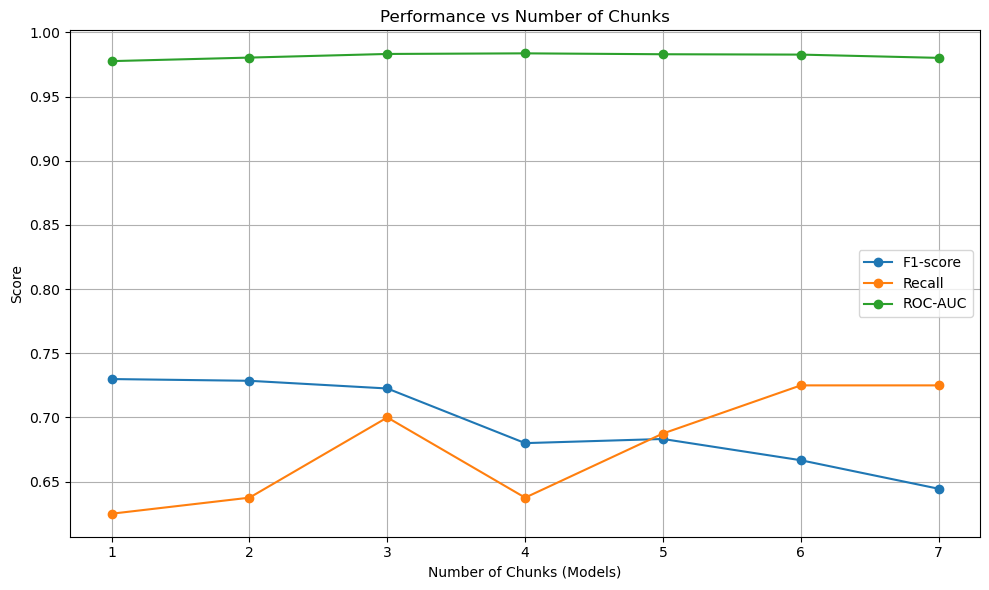

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support

# === 預備：切分訓練 / 測試 ===
X_all = df_cleaned.drop(columns=['account_number', 'customer_id', 'is_suspicious'])
y_all = df_cleaned['is_suspicious']
X_train_all, X_test, y_train_all, y_test = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)

train_df = X_train_all.copy()
train_df['is_suspicious'] = y_train_all.values

# === 記錄不同切分的結果 ===
results = []

# === 開始嘗試不同切分數量 ===
for n_chunks in range(1, 8):  # 測試從 2 到 7 份
    print(f"\n=== 切 {n_chunks} 份 ===")
    pos_df = train_df[train_df['is_suspicious'] == 1]
    neg_df = train_df[train_df['is_suspicious'] == 0]

    chunk_size = len(neg_df) // n_chunks
    neg_chunks = [neg_df.iloc[i * chunk_size : (i + 1) * chunk_size] for i in range(n_chunks)]
    if len(neg_df) % n_chunks != 0:
        neg_chunks[-1] = pd.concat([neg_chunks[-1], neg_df.iloc[n_chunks * chunk_size:]])

    models = []
    for i, neg_chunk in enumerate(neg_chunks):
        sub_df = pd.concat([pos_df, neg_chunk])
        X_sub = sub_df.drop(columns=['is_suspicious'])
        y_sub = sub_df['is_suspicious']

        model = LGBMClassifier(n_estimators=300, class_weight='balanced', random_state=i)
        model.fit(X_sub, y_sub)
        models.append(model)

    # 預測
    probs = [model.predict_proba(X_test)[:, 1] for model in models]
    avg_prob = np.mean(probs, axis=0)
    y_pred = (avg_prob >= 0.5).astype(int)

    # 評估
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    auc = roc_auc_score(y_test, avg_prob)

    results.append({
        'n_chunks': n_chunks,
        'f1_score': f1,
        'recall': recall,
        'precision': precision,
        'roc_auc': auc
    })

# === 轉為 DataFrame ===
results_df = pd.DataFrame(results)
display(results_df)

# === 畫圖 ===
plt.figure(figsize=(10, 6))
plt.plot(results_df['n_chunks'], results_df['f1_score'], marker='o', label='F1-score')
plt.plot(results_df['n_chunks'], results_df['recall'], marker='o', label='Recall')
plt.plot(results_df['n_chunks'], results_df['roc_auc'], marker='o', label='ROC-AUC')
plt.xticks(results_df['n_chunks'])
plt.xlabel('Number of Chunks (Models)')
plt.ylabel('Score')
plt.title('Performance vs Number of Chunks')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



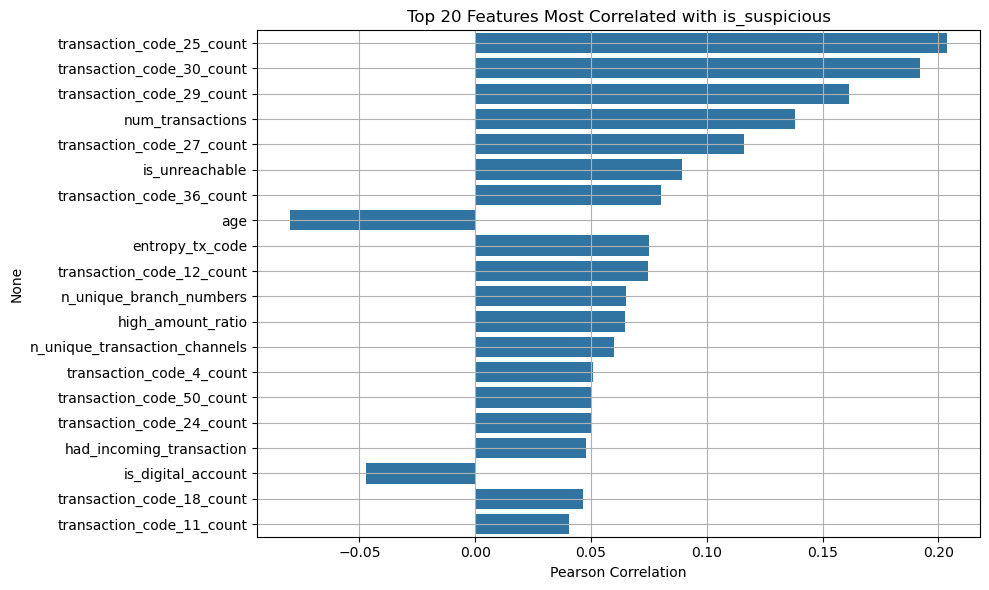

transaction_code_25_count        0.203812
transaction_code_30_count        0.192150
transaction_code_29_count        0.161361
num_transactions                 0.138114
transaction_code_27_count        0.115943
is_unreachable                   0.089309
transaction_code_36_count        0.080173
age                             -0.079977
entropy_tx_code                  0.075229
transaction_code_12_count        0.074729
n_unique_branch_numbers          0.065281
high_amount_ratio                0.064480
n_unique_transaction_channels    0.059869
transaction_code_4_count         0.050851
transaction_code_50_count        0.050215
transaction_code_24_count        0.049845
had_incoming_transaction         0.047702
is_digital_account              -0.047058
transaction_code_18_count        0.046490
transaction_code_11_count        0.040484
Name: is_suspicious, dtype: float64

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt

# 計算數值特徵與 is_suspicious 的皮爾森相關係數
corr_matrix = df_cleaned.corr(numeric_only=True)

# 取與目標變數 is_suspicious 的相關性
target_corr = corr_matrix['is_suspicious'].drop('is_suspicious').sort_values(key=abs, ascending=False)

# 顯示前 20 名最相關特徵
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.values[:20], y=target_corr.index[:20])
plt.title("Top 20 Features Most Correlated with is_suspicious")
plt.xlabel("Pearson Correlation")
plt.grid(True)
plt.tight_layout()
plt.show()

# 同時輸出相關係數表
display(target_corr.head(20))


In [223]:
import pandas as pd 
import numpy as np
from functools import reduce
from scipy.stats import entropy
import joblib

# === 1. 讀取資料 ===
account_info = pd.read_csv('./data/Train/train_account_info.csv')
customer_info = pd.read_csv('./data/Train/train_customer_info.csv')
transactions = pd.read_csv('./data/Train/train_account_transactions.csv')

# === 2. 型別一致化 ===
account_info['account_number'] = account_info['account_number'].astype(str)
customer_info['customer_id'] = customer_info['customer_id'].astype(str)
transactions['account_number'] = transactions['account_number'].astype(str)
transactions['counterparty_account'] = transactions['counterparty_account'].astype(str)

# === 3. 合併主檔 ===
merged = pd.merge(account_info, customer_info, on='customer_id', how='left')

# === 4. 基本交易特徵 ===
in_df = transactions[transactions['transaction_direction'] == 1]
out_df = transactions[transactions['transaction_direction'] == 0]

total_in = in_df.groupby('account_number')['transaction_amount'].sum().reset_index(name='total_amount_in')
total_out = out_df.groupby('account_number')['transaction_amount'].sum().reset_index(name='total_amount_out')
avg_in = in_df.groupby('account_number')['transaction_amount'].mean().reset_index(name='avg_amount_in')
avg_out = out_df.groupby('account_number')['transaction_amount'].mean().reset_index(name='avg_amount_out')
count_df = transactions.groupby('account_number')['transaction_amount'].count().reset_index(name='num_transactions')

minmax = transactions.groupby('account_number')['transaction_amount'].agg(
    max_transaction_amount='max',
    min_transaction_amount='min'
).reset_index()

has_in = total_in.assign(had_incoming_transaction=1)[['account_number', 'had_incoming_transaction']]
has_out = total_out.assign(had_outgoing_transaction=1)[['account_number', 'had_outgoing_transaction']]

n_channels = transactions.groupby('account_number')['transaction_channel'].nunique().reset_index(name='n_unique_transaction_channels')
n_branches = transactions.groupby('account_number')['branch_number'].nunique().reset_index(name='n_unique_branch_numbers')
n_targets = transactions.groupby('account_number')['counterparty_account'].nunique().reset_index(name='n_unique_target_accounts')

# === 5. 固定交易代碼欄位展開 ===
all_transaction_codes = joblib.load('./data/transaction_code_list.pkl')
tx_code_pivot = transactions.pivot_table(index='account_number',
                                         columns='transaction_code',
                                         values='transaction_amount',
                                         aggfunc='count',
                                         fill_value=0)
for code in all_transaction_codes:
    if code not in tx_code_pivot.columns:
        tx_code_pivot[code] = 0
tx_code_pivot = tx_code_pivot[[code for code in all_transaction_codes]]
tx_code_pivot.columns = [f'transaction_code_{int(col)}_count' for col in tx_code_pivot.columns]
tx_code_pivot = tx_code_pivot.reset_index()

# === 6. 五個進階特徵 ===
in_out = pd.merge(total_in, total_out, on='account_number', how='outer').fillna(0)
in_out['in_out_ratio'] = in_out['total_amount_in'] / (in_out['total_amount_out'] + 1)
in_out = in_out[['account_number', 'in_out_ratio']]

high_thresh = transactions['transaction_amount'].quantile(0.9)
high_tx_ratio = transactions.groupby('account_number').apply(
    lambda x: (x['transaction_amount'] > high_thresh).sum() / len(x)
).reset_index(name='high_amount_ratio')

transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
n_days = transactions.groupby('account_number')['transaction_date'].nunique().reset_index(name='n_active_days')

avg_gap = transactions.sort_values(['account_number', 'transaction_date']).groupby('account_number')['transaction_date'].apply(
    lambda x: np.mean(np.diff(x).astype('timedelta64[D]')) if len(x) > 1 else 0
).reset_index(name='avg_days_between_tx')
avg_gap['avg_days_between_tx'] = avg_gap['avg_days_between_tx'].astype(float)

def tx_entropy(x):
    counts = x['transaction_code'].value_counts()
    return entropy(counts / counts.sum())

entropy_tx = transactions.groupby('account_number').apply(tx_entropy).reset_index(name='entropy_tx_code')

# === 7. 三個交互特徵 ===
entropy_thresh = entropy_tx['entropy_tx_code'].median()
high_amount_thresh = high_tx_ratio['high_amount_ratio'].median()

high_amount_and_entropy = pd.merge(high_tx_ratio, entropy_tx, on='account_number')
high_amount_and_entropy['high_amount_and_entropy'] = (
    (high_amount_and_entropy['high_amount_ratio'] > high_amount_thresh) &
    (high_amount_and_entropy['entropy_tx_code'] > entropy_thresh)
).astype(int)
high_amount_and_entropy = high_amount_and_entropy[['account_number', 'high_amount_and_entropy']]

is_digital_and_active = pd.merge(account_info[['account_number', 'is_digital_account']], n_days, on='account_number')
is_digital_and_active['is_digital_and_active'] = (
    (is_digital_and_active['is_digital_account'] == 1) &
    (is_digital_and_active['n_active_days'] > 10)
).astype(int)
is_digital_and_active = is_digital_and_active[['account_number', 'is_digital_and_active']]

many_branches_and_tx = pd.merge(n_branches, count_df, on='account_number')
many_branches_and_tx['many_branches_and_tx'] = (
    (many_branches_and_tx['n_unique_branch_numbers'] >= 5) &
    (many_branches_and_tx['num_transactions'] >= 100)
).astype(int)
many_branches_and_tx = many_branches_and_tx[['account_number', 'many_branches_and_tx']]

# === 8. 近 7 天時間序列特徵 ===
latest_date = transactions['transaction_date'].max()
recent_7day_tx = transactions[transactions['transaction_date'] >= latest_date - pd.Timedelta(days=7)]

recent_7day_count = recent_7day_tx.groupby('account_number')['transaction_amount'].count().reset_index(name='recent_7day_tx_count')
recent_7day_avg = recent_7day_tx.groupby('account_number')['transaction_amount'].mean().reset_index(name='recent_7day_avg_amt')

# === 9. 合併所有特徵 ===
tx_features = [
    total_in, total_out, avg_in, avg_out, count_df, minmax,
    has_in, has_out, n_channels, n_branches, n_targets,
    tx_code_pivot, in_out, high_tx_ratio, n_days, avg_gap, entropy_tx,
    high_amount_and_entropy, is_digital_and_active, many_branches_and_tx,
    recent_7day_count, recent_7day_avg
]

tx_merged = reduce(lambda left, right: pd.merge(left, right, on='account_number', how='outer'), tx_features).fillna(0)

# === 10. 合併回主資料 ===
final_train = pd.merge(merged, tx_merged, on='account_number', how='left').fillna(0)

# === 11. 匯出結果 ===
final_train.to_csv('./data/Train/train_customer__account_info_trans_with_all_features.csv', index=False)

C:\Users\USER\AppData\Local\Temp\ipykernel_21048\4145907836.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_tx_ratio = transactions.groupby('account_number').apply(
C:\Users\USER\AppData\Local\Temp\ipykernel_21048\4145907836.py:79: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_tx = transactions.groupby('account_number').apply(tx_entropy).reset_index(name='entropy_tx_code')


In [224]:
print(len(final_train.columns))

81


In [225]:
# 讀取警示帳戶資料（標記為可疑的帳戶）
suspicious_df = pd.read_csv('./data/Train/train_suspicious_accounts.csv')

# 建立標籤欄位，代表此帳戶是否為可疑帳戶
suspicious_df['is_suspicious'] = 1

# 合併標籤進主資料（依據 account_number）
final_train = pd.merge(final_train, suspicious_df[['account_number', 'is_suspicious']], on='account_number', how='left')

# 對於未出現在警示名單中的帳戶，標記為 0（非可疑）
final_train['is_suspicious'] = final_train['is_suspicious'].fillna(0).astype(int)
final_train.to_csv('./data/Train/train_customer__account_info_trans_with_all_features.csv', index=False)

In [226]:
# 1. 讀取資料
df = pd.read_csv('./data/Train/train_customer__account_info_trans_with_extra_features.csv')

# 清除所有含有 NaN 的列（會影響約 2,000 筆）
df_cleaned = df.dropna()

# 儲存清理後資料（可選）
df_cleaned.to_csv('./data/Train/train_customer__account_info_trans_with_all_features_cleaned.csv', index=False)

# 檢查剩下筆數與是否有缺失
print(f"原始筆數: {df.shape[0]}")
print(f"清理後筆數: {df_cleaned.shape[0]}")
print("剩餘缺失值總數:", df_cleaned.isna().sum().sum())

原始筆數: 24969
清理後筆數: 24969
剩餘缺失值總數: 0



=== 切 1 份 ===

=== 切 2 份 ===

=== 切 3 份 ===

=== 切 4 份 ===

=== 切 5 份 ===

=== 切 6 份 ===

=== 切 7 份 ===


,n_chunks,f1_score,recall,precision,roc_auc
0,1,0.742424,0.6125,0.942308,0.980533
1,2,0.723404,0.6375,0.836066,0.984081
2,3,0.711409,0.6625,0.768116,0.982323
3,4,0.683544,0.6750,0.692308,0.981466
4,5,0.703704,0.7125,0.695122,0.982407
5,6,0.662722,0.7000,0.629213,0.983326
6,7,0.677596,0.7750,0.601942,0.982397


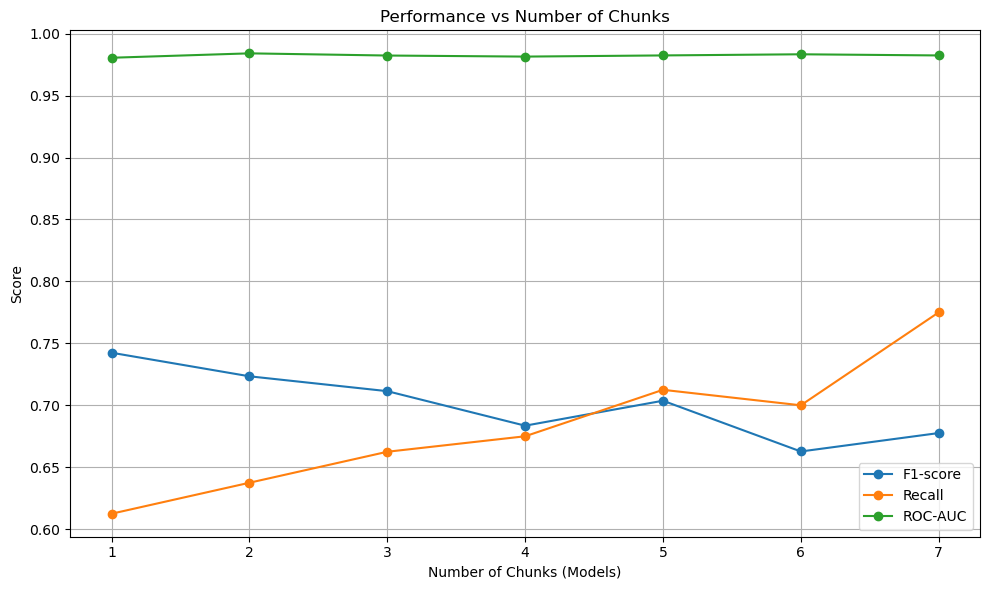

In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support

# === 預備：切分訓練 / 測試 ===
X_all = df_cleaned.drop(columns=['account_number', 'customer_id', 'is_suspicious'])
y_all = df_cleaned['is_suspicious']
X_train_all, X_test, y_train_all, y_test = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)

train_df = X_train_all.copy()
train_df['is_suspicious'] = y_train_all.values

# === 記錄不同切分的結果 ===
results = []

# === 開始嘗試不同切分數量 ===
for n_chunks in range(1, 8):  # 測試從 2 到 7 份
    print(f"\n=== 切 {n_chunks} 份 ===")
    pos_df = train_df[train_df['is_suspicious'] == 1]
    neg_df = train_df[train_df['is_suspicious'] == 0]

    chunk_size = len(neg_df) // n_chunks
    neg_chunks = [neg_df.iloc[i * chunk_size : (i + 1) * chunk_size] for i in range(n_chunks)]
    if len(neg_df) % n_chunks != 0:
        neg_chunks[-1] = pd.concat([neg_chunks[-1], neg_df.iloc[n_chunks * chunk_size:]])

    models = []
    for i, neg_chunk in enumerate(neg_chunks):
        sub_df = pd.concat([pos_df, neg_chunk])
        X_sub = sub_df.drop(columns=['is_suspicious'])
        y_sub = sub_df['is_suspicious']

        model = LGBMClassifier(n_estimators=300, class_weight='balanced', random_state=i)
        model.fit(X_sub, y_sub)
        models.append(model)

    # 預測
    probs = [model.predict_proba(X_test)[:, 1] for model in models]
    avg_prob = np.mean(probs, axis=0)
    y_pred = (avg_prob >= 0.5).astype(int)

    # 評估
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    auc = roc_auc_score(y_test, avg_prob)

    results.append({
        'n_chunks': n_chunks,
        'f1_score': f1,
        'recall': recall,
        'precision': precision,
        'roc_auc': auc
    })

# === 轉為 DataFrame ===
results_df = pd.DataFrame(results)
display(results_df)

# === 畫圖 ===
plt.figure(figsize=(10, 6))
plt.plot(results_df['n_chunks'], results_df['f1_score'], marker='o', label='F1-score')
plt.plot(results_df['n_chunks'], results_df['recall'], marker='o', label='Recall')
plt.plot(results_df['n_chunks'], results_df['roc_auc'], marker='o', label='ROC-AUC')
plt.xticks(results_df['n_chunks'])
plt.xlabel('Number of Chunks (Models)')
plt.ylabel('Score')
plt.title('Performance vs Number of Chunks')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [228]:
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
import pandas as pd

# 讀資料

# 切分訓練 / 驗證集
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df_cleaned['is_suspicious'], random_state=42)

# 訓練 AutoGluon
predictor = TabularPredictor(label='is_suspicious', eval_metric='f1', path='./autogluon_model') \
    .fit(train_data=train_df, tuning_data=val_df, time_limit=600)

# 顯示模型 leaderboard（含 F1 分數）
predictor.leaderboard(val_df, silent=True, extra_metrics=["roc_auc", "precision", "recall"])


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
Memory Avail:       3.06 GB / 15.93 GB (19.2%)
Disk Space Avail:   1466.83 GB / 1818.02 GB (80.7%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference speed.
	presets='good'         : Good accu

,model,score_test,roc_auc,precision,recall,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.765957,0.980558,0.885246,0.6750,0.724409,f1,0.113997,0.079000,101.083010,0.013998,0.002000,0.617994,2,True,14
1,CatBoost,0.740741,0.974830,0.909091,0.6250,0.714286,f1,0.022002,0.009001,59.895145,0.022002,0.009001,59.895145,1,True,7
2,XGBoost,0.716418,0.975348,0.888889,0.6000,0.693548,f1,0.039001,0.028000,3.055043,0.039001,0.028000,3.055043,1,True,11
3,LightGBM,0.706767,0.973174,0.886792,0.5875,0.692913,f1,0.040000,0.033002,2.401003,0.040000,0.033002,2.401003,1,True,4
4,LightGBMXT,0.696970,0.967516,0.884615,0.5750,0.704000,f1,0.038997,0.022002,2.287131,0.038997,0.022002,2.287131,1,True,3
5,NeuralNetFastAI,0.681159,0.963317,0.810345,0.5875,0.688525,f1,0.084999,0.061999,24.429041,0.084999,0.061999,24.429041,1,True,10
6,ExtraTreesGini,0.680851,0.973155,0.786885,0.6000,0.431373,f1,0.122997,0.064565,0.899648,0.122997,0.064565,0.899648,1,True,8
7,RandomForestEntr,0.676056,0.972203,0.774194,0.6000,0.584071,f1,0.100021,0.063000,1.316592,0.100021,0.063000,1.316592,1,True,6
8,RandomForestGini,0.661972,0.972254,0.758065,0.5875,0.571429,f1,0.098019,0.062508,1.533482,0.098019,0.062508,1.533482,1,True,5
9,ExtraTreesEntr,0.656934,0.963717,0.789474,0.5625,0.431373,f1,0.114016,0.062509,0.867557,0.114016,0.062509,0.867557,1,True,9
